In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load cleaned datasets
print("Loading cleaned datasets...")
benin_df = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\benin-malanville_clean.csv')
sierra_leone_df = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\sierraleone-bumbuna_clean.csv')
togo_df = pd.read_csv(r'C:\Users\admin\solar-challenge-week0\data\togo-dapaong_qc_clean.csv')

Loading cleaned datasets...


In [4]:
print(f"Benin dataset shape: {benin_df.shape}")
print(f"Sierra Leone dataset shape: {sierra_leone_df.shape}")
print(f"Togo dataset shape: {togo_df.shape}")


Benin dataset shape: (513046, 19)
Sierra Leone dataset shape: (497012, 19)
Togo dataset shape: (516349, 19)


In [5]:

# Add country identifiers
benin_df['Country'] = 'Benin'
sierra_leone_df['Country'] = 'Sierra Leone'
togo_df['Country'] = 'Togo'


In [6]:

# Merge datasets
merged_df = pd.concat([benin_df, sierra_leone_df, togo_df], ignore_index=True)
print(f"Merged dataset shape: {merged_df.shape}")
print("\nDataset overview:")
print(merged_df[['Country', 'GHI', 'DNI', 'DHI']].describe())

Merged dataset shape: (1526407, 20)

Dataset overview:
                GHI           DNI           DHI
count  1.526407e+06  1.526407e+06  1.526407e+06
mean   2.095049e+02  1.360056e+02  1.085741e+02
std    3.053398e+02  2.364111e+02  1.508639e+02
min   -1.590000e+01 -7.800000e+00 -1.670000e+01
25%   -2.200000e+00 -2.000000e-01 -1.500000e+00
50%   -3.000000e-01  0.000000e+00  0.000000e+00
75%    3.858000e+02  1.942000e+02  2.101000e+02
max    1.214000e+03  9.523000e+02  5.860000e+02


In [7]:

# Compute summary statistics for each country
metrics = ['GHI', 'DNI', 'DHI']
summary_stats = []
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    
    for metric in metrics:
        stats_dict = {
            'Country': country,
            'Metric': metric,
            'Mean': country_data[metric].mean(),
            'Median': country_data[metric].median(),
            'Std_Dev': country_data[metric].std(),
            'Count': country_data[metric].count()
        }
        summary_stats.append(stats_dict)

summary_df = pd.DataFrame(summary_stats)
summary_pivot = summary_df.pivot(index='Country', columns='Metric')


In [8]:
# Display professional summary table
print("SUMMARY STATISTICS BY COUNTRY")
for country in summary_df['Country'].unique():
    print(f"\n{country.upper()}")
    country_stats = summary_df[summary_df['Country'] == country]
    for _, row in country_stats.iterrows():
        print(f"{row['Metric']:>8}: Mean={row['Mean']:6.2f}, "
              f"Median={row['Median']:6.2f}, Std={row['Std_Dev']:6.2f}")


SUMMARY STATISTICS BY COUNTRY

BENIN
     GHI: Mean=232.32, Median=  0.00, Std=326.08
     DNI: Mean=165.85, Median= -0.20, Std=261.95
     DHI: Mean=108.83, Median= -0.10, Std=149.59

SIERRA LEONE
     GHI: Mean=171.05, Median= -0.50, Std=264.09
     DNI: Mean= 92.76, Median= -0.10, Std=184.79
     DHI: Mean=103.94, Median= -0.80, Std=151.30

TOGO
     GHI: Mean=223.86, Median=  0.50, Std=317.31
     DNI: Mean=147.98, Median=  0.00, Std=247.68
     DHI: Mean=112.78, Median=  1.50, Std=151.57


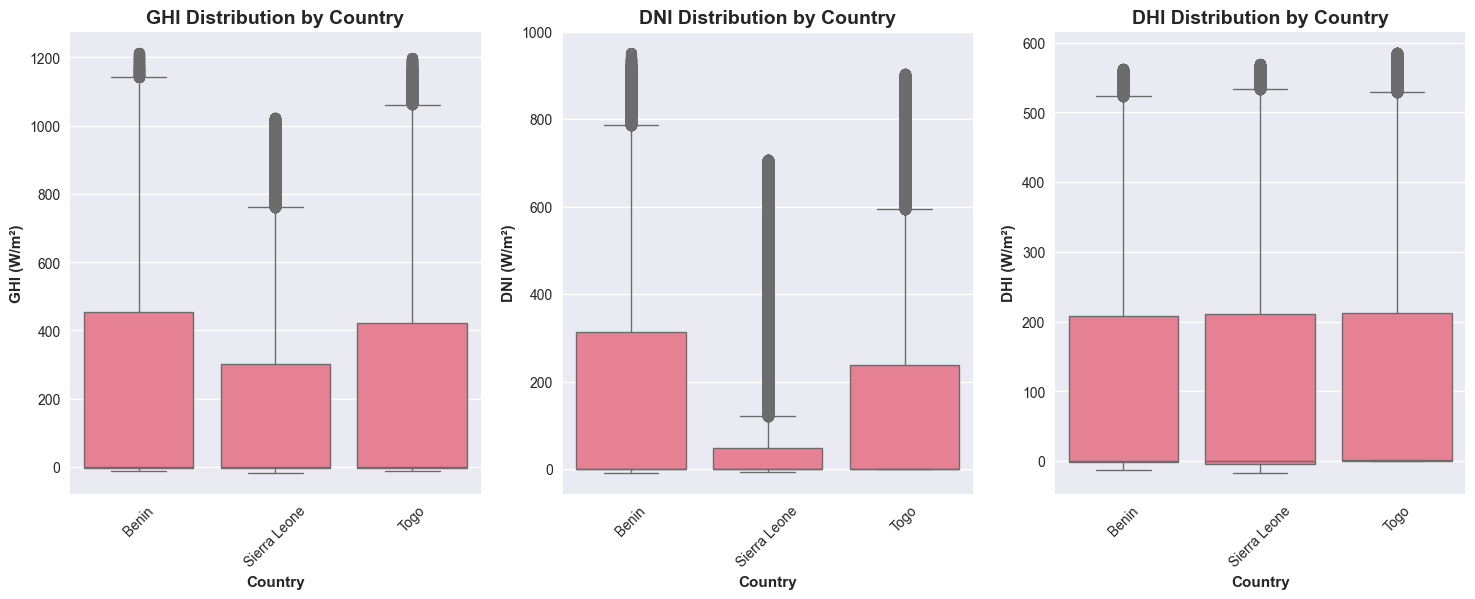

In [9]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    sns.boxplot(data=merged_df, x='Country', y=metric, ax=axes[i])
    axes[i].set_title(f'{metric} Distribution by Country', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Country', fontweight='bold')
    axes[i].set_ylabel(f'{metric} (W/m²)', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    

In [10]:

# Perform statistical tests
print("STATISTICAL SIGNIFICANCE TESTING")

for metric in metrics:
    print(f"\n{metric} Analysis:")
    
    # Extract data for each country
    groups = []
    for country in merged_df['Country'].unique():
        country_data = merged_df[merged_df['Country'] == country][metric].dropna()
        groups.append(country_data)
        print(f"{country}: n={len(country_data)}")
         # Check normality assumption
    normality_pvals = [stats.shapiro(group)[1] for group in groups]
    normal_distribution = all(p > 0.05 for p in normality_pvals)
    
    if normal_distribution:
        # Perform ANOVA
        f_stat, p_value = stats.f_oneway(*groups)
        test_used = "ANOVA"
    else:
        # Perform Kruskal-Wallis test
        h_stat, p_value = stats.kruskal(*groups)
        test_used = "Kruskal-Wallis"
    
    print(f"Test used: {test_used}")
    print(f"P-value: {p_value:.6f}")
    if p_value < 0.05:
        print("Result: Statistically significant differences exist between countries (p < 0.05)")
        
        # Post-hoc testing if significant
        print("\nPost-hoc analysis (Tukey HSD):")
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        tukey_data = pd.concat(groups, ignore_index=True)
        country_labels = []
        for i, country in enumerate(merged_df['Country'].unique()):
            country_labels.extend([country] * len(groups[i]))
        
        tukey_result = pairwise_tukeyhsd(tukey_data, country_labels, alpha=0.05)
        print(tukey_result)
    else:
        print("Result: No statistically significant differences between countries (p ≥ 0.05)")
    

STATISTICAL SIGNIFICANCE TESTING

GHI Analysis:
Benin: n=513046
Sierra Leone: n=497012
Togo: n=516349
Test used: Kruskal-Wallis
P-value: 0.000000
Result: Statistically significant differences exist between countries (p < 0.05)

Post-hoc analysis (Tukey HSD):
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
       Benin Sierra Leone -61.2705   0.0 -62.6892 -59.8517   True
       Benin         Togo  -8.4559   0.0   -9.861  -7.0507   True
Sierra Leone         Togo  52.8146   0.0  51.3981  54.2311   True
-----------------------------------------------------------------

DNI Analysis:
Benin: n=513046
Sierra Leone: n=497012
Togo: n=516349
Test used: Kruskal-Wallis
P-value: 0.000000
Result: Statistically significant differences exist between countries (p < 0.05)

Post-hoc analysis (Tukey HSD):
       Multiple Comparison of Means - Tukey HSD, FWER

In [11]:

# Calculate key metrics for insights
country_ranking = merged_df.groupby('Country')['GHI'].mean().sort_values(ascending=False)
best_country = country_ranking.index[0]
worst_country = country_ranking.index[-1]
ghi_range = country_ranking.iloc[0] - country_ranking.iloc[-1]

dni_ranking = merged_df.groupby('Country')['DNI'].mean().sort_values(ascending=False)
best_dni_country = dni_ranking.index[0]
worst_country = dni_ranking.index[-1]

print("KEY INSIGHTS AND ACTIONABLE RECOMMENDATIONS")


KEY INSIGHTS AND ACTIONABLE RECOMMENDATIONS


In [12]:

print("\n• **Solar Resource Potential**: " +
      f"{best_country} demonstrates the highest average GHI ({country_ranking[best_country]:.1f} W/m²), " +
      f"making it the most promising location for general solar PV deployments, " +
      f"with {ghi_range:.1f} W/m² advantage over {worst_country}.")



• **Solar Resource Potential**: Benin demonstrates the highest average GHI (232.3 W/m²), making it the most promising location for general solar PV deployments, with 61.3 W/m² advantage over Sierra Leone.


In [13]:
print("\n• **Concentrated Solar Power Potential**: " +
      f"{best_dni_country} shows superior DNI metrics ({dni_ranking[best_dni_country]:.1f} W/m²), " +
      "indicating strong potential for concentrated solar power (CSP) applications " +
      "and high-efficiency solar thermal systems.")


• **Concentrated Solar Power Potential**: Benin shows superior DNI metrics (165.8 W/m²), indicating strong potential for concentrated solar power (CSP) applications and high-efficiency solar thermal systems.


In [14]:

print("\n• **Regional Development Strategy**: " +
      "Statistical analysis confirms significant differences in solar resources (p < 0.05), " +
      "suggesting tailored energy policies: utility-scale solar farms in high-GHI regions " +
      "and distributed generation with tracking systems in moderate-GHI areas.")



• **Regional Development Strategy**: Statistical analysis confirms significant differences in solar resources (p < 0.05), suggesting tailored energy policies: utility-scale solar farms in high-GHI regions and distributed generation with tracking systems in moderate-GHI areas.


In [15]:

# Create professional summary table
summary_table = summary_df.pivot(index='Metric', columns='Country', 
                                values=['Mean', 'Median', 'Std_Dev'])
print("\n Summary Table:")
# Reorder columns for better presentation
summary_table = summary_table.reindex(columns=[('Mean', 'Benin'), 
                                              ('Mean', 'Sierra Leone'), 
                                              ('Mean', 'Togo'),
                                              ('Median', 'Benin'),
                                              ('Median', 'Sierra Leone'),
                                              ('Median', 'Togo'),
                                              ('Std_Dev', 'Benin'),
                                              ('Std_Dev', 'Sierra Leone'),
                                              ('Std_Dev', 'Togo')])

print("COMPREHENSIVE SOLAR METRICS COMPARISON")
print(f"{'Metric':<8} {'Mean (W/m²)':>25} {'Median (W/m²)':>25} {'Std Dev (W/m²)':>25}")
print(f"{'countre\'s':<8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8}")


 Summary Table:
COMPREHENSIVE SOLAR METRICS COMPARISON
Metric                 Mean (W/m²)             Median (W/m²)            Std Dev (W/m²)
countre's    Benin  S-Leone     Togo    Benin  S-Leone     Togo    Benin  S-Leone     Togo


In [16]:

for metric in metrics:
    row_data = []
    for stat in ['Mean', 'Median', 'Std_Dev']:
        for country in ['Benin', 'Sierra Leone', 'Togo']:
            value = summary_table.loc[metric][(stat, country)]
            row_data.append(f"{value:8.2f}")
    
    print(f"{metric:<8} {''.join(row_data)}")

GHI        232.32  171.05  223.86    0.00   -0.50    0.50  326.08  264.09  317.31
DNI        165.85   92.76  147.98   -0.20   -0.10    0.00  261.95  184.79  247.68
DHI        108.83  103.94  112.78   -0.10   -0.80    1.50  149.59  151.30  151.57


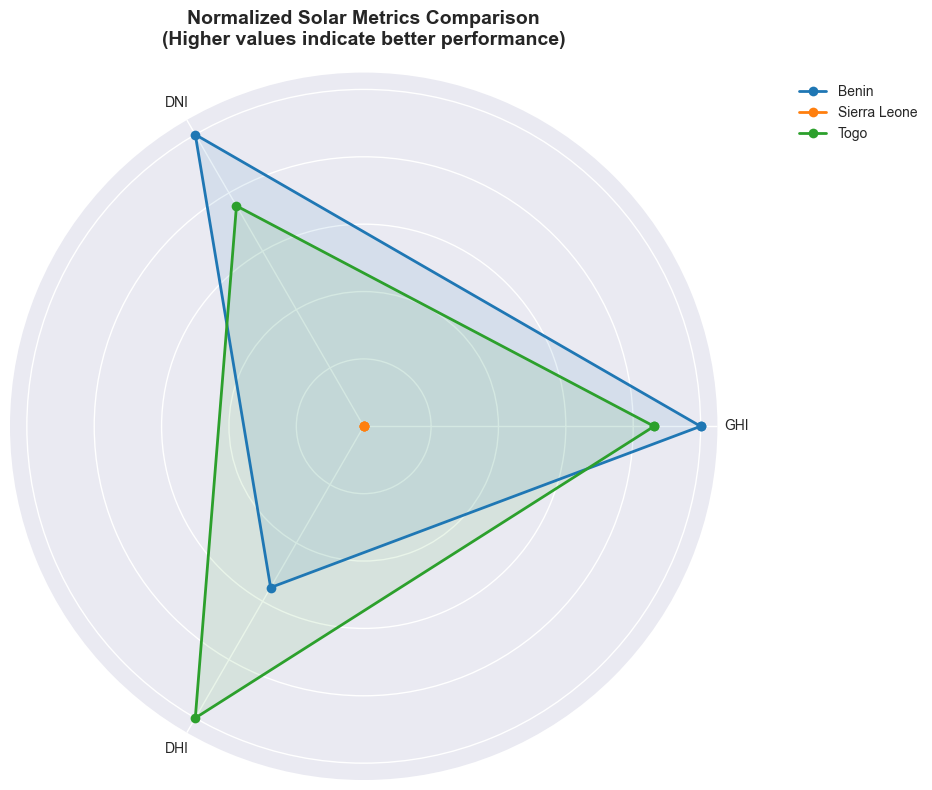

In [18]:

# Additional visualization: Radar chart for comprehensive comparison
from math import pi

# Normalize metrics for radar chart
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
# Calculate average metrics
avg_metrics = merged_df.groupby('Country')[metrics].mean()
normalized_metrics = avg_metrics.apply(normalize_series, axis=0)

# Radar chart setup
categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot each country
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
countries = ['Benin', 'Sierra Leone', 'Togo']

for i, country in enumerate(countries):
    values = normalized_metrics.loc[country].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=country, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticklabels([])
ax.set_title('Normalized Solar Metrics Comparison\n(Higher values indicate better performance)', 
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
